In [1]:
%matplotlib inline

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

import torchvision
import torchvision.transforms as transforms
from torchvision.utils import make_grid

import matplotlib.pyplot as plt
import numpy as np

import sklearn
from sklearn.manifold import TSNE

In [2]:
batch_size = 128
train_set, test_set, train_loader, test_loader = {},{},{},{}
transform = transforms.Compose(
    [transforms.ToTensor()])

train_set['fashionmnist'] = torchvision.datasets.FashionMNIST(root='./data', train=True, download=True, transform=transform)
test_set['fashionmnist'] = torchvision.datasets.FashionMNIST(root='./data', train=False, download=True, transform=transform)

train_loader['fashionmnist'] = torch.utils.data.DataLoader(train_set['fashionmnist'], batch_size=batch_size, shuffle=True, num_workers=0)
test_loader['fashionmnist'] = torch.utils.data.DataLoader(test_set['fashionmnist'], batch_size=batch_size, shuffle=False, num_workers=0)

device = 'cuda'

In [3]:
# c-VAE
class VAE(nn.Module):
    def __init__(self, n_in, n_hid, z_dim, n_class=10):
        super(VAE, self).__init__()
        
        self.fc1 = nn.Linear(n_in + n_class, n_hid)
        self.fc21 = nn.Linear(n_hid, z_dim)
        self.fc22 = nn.Linear(n_hid, z_dim)
        self.fc3 = nn.Linear(z_dim + n_class, n_hid)
        self.fc4 = nn.Linear(n_hid, n_in)

    def encode(self, x, targets):
        x_targets = torch.cat((x, targets), 1)
        h1 = F.relu(self.fc1(x_targets))
        return self.fc21(h1), self.fc22(h1)

    def reparameterize(self, mu, logvar):
        stdev = torch.exp(0.5*logvar)
        eps = torch.randn_like(stdev)
        return mu + eps*stdev

    def decode(self, z, targets):
        z_targets = torch.cat((z, targets), 1)
        h3 = F.relu(self.fc3(z_targets))
        return torch.sigmoid(self.fc4(h3))

    def forward(self, x, targets):
        mu, logvar = self.encode(x, targets)
        z = self.reparameterize(mu, logvar)
        return self.decode(z, targets), mu, logvar

def loss_function(recon_x, x, mu, logvar):
    BCE = F.binary_cross_entropy(recon_x, x, reduction='sum') 
    KLD = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp()) 
    return BCE + KLD

In [4]:
def train(model, device, train_loader, optimizer, epoch):
    train_loss = 0
    model.train()
    for batch_idx, (data, target) in enumerate(train_loader):
        data = data.view(data.size(0),-1)
        data = data.to(device)
        one_hot_target = torch.eye(10)[target]
        one_hot_target = one_hot_target.to(device)
        optimizer.zero_grad()
        output, mu, logvar = model(data, one_hot_target)
        loss = loss_function(output, data, mu, logvar)
        loss.backward()
        optimizer.step()
        train_loss += loss.item()
        if batch_idx % (len(train_loader)//2) == 0:
            print('Train({})[{:.0f}%]: Loss: {:.4f}'.format(
                epoch, 100. * batch_idx / len(train_loader), train_loss/(batch_idx+1)))
    return train_loss

def test(model, device, test_loader, epoch):
    model.eval()
    test_loss = 0
    with torch.no_grad():
        for data, target in test_loader:
            data = data.view(data.size(0),-1)
            data = data.to(device)
            one_hot_target = torch.eye(10)[target]
            one_hot_target = one_hot_target.to(device)
            output, mu, logvar = model(data, one_hot_target)
            loss = loss_function(output, data, mu, logvar)
            test_loss += loss.item() # sum up batch loss
    test_loss = (test_loss*batch_size)/len(test_loader.dataset)
    print('Test({}): Loss: {:.4f}'.format(
        epoch, test_loss))
    return test_loss

In [5]:
def make_optimizer(optimizer_name, model, **kwargs):
    if optimizer_name=='Adam':
        optimizer = optim.Adam(model.parameters(),lr=kwargs['lr'])
    elif optimizer_name=='SGD':
        optimizer = optim.SGD(model.parameters(),lr=kwargs['lr'],momentum=kwargs['momentum'], weight_decay=kwargs['weight_decay'])
    else:
        raise ValueError('Not valid optimizer name')
    return optimizer

In [6]:
seed = 1
data_name = 'fashionmnist'
optimizer_name = 'Adam'

num_epochs = 10
lr = 0.001
n_in = 28*28
n_hid = 400
z_dim = 20

device = torch.device(device)
torch.manual_seed(seed)
torch.cuda.manual_seed(seed)

vae = VAE(n_in, n_hid, z_dim).to(device)

optimizer = make_optimizer(optimizer_name, vae, lr=lr)

for epoch in range(1, num_epochs + 1):
    train(vae, device, train_loader[data_name], optimizer, epoch)

test(vae, device, test_loader[data_name], epoch)

Train(1)[0%]: Loss: 70083.8594
Train(1)[50%]: Loss: 38963.8046
Train(1)[100%]: Loss: 36318.1078
Train(2)[0%]: Loss: 33505.7773
Train(2)[50%]: Loss: 32839.7555
Train(2)[100%]: Loss: 32469.7125
Train(3)[0%]: Loss: 31721.6484
Train(3)[50%]: Loss: 31870.6509
Train(3)[100%]: Loss: 31729.3977
Train(4)[0%]: Loss: 31301.7988
Train(4)[50%]: Loss: 31435.2891
Train(4)[100%]: Loss: 31353.3350
Train(5)[0%]: Loss: 31669.6406
Train(5)[50%]: Loss: 31220.1586
Train(5)[100%]: Loss: 31130.9139
Train(6)[0%]: Loss: 32443.0137
Train(6)[50%]: Loss: 30989.9468
Train(6)[100%]: Loss: 30969.5732
Train(7)[0%]: Loss: 30696.2773
Train(7)[50%]: Loss: 30914.5117
Train(7)[100%]: Loss: 30853.8835
Train(8)[0%]: Loss: 30572.3320
Train(8)[50%]: Loss: 30872.5322
Train(8)[100%]: Loss: 30762.3338
Train(9)[0%]: Loss: 30048.1543
Train(9)[50%]: Loss: 30688.7445
Train(9)[100%]: Loss: 30686.4630
Train(10)[0%]: Loss: 31000.2871
Train(10)[50%]: Loss: 30577.2209
Train(10)[100%]: Loss: 30621.9581
Test(10): Loss: 30843.3703


30843.370259375

/opt/conda/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/opt/conda/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


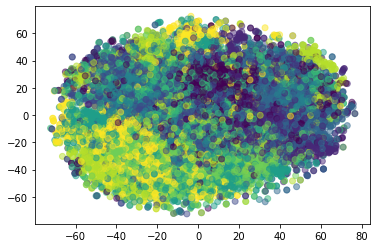

In [10]:
def plot_manifold(input_model):
    latent_vectors = []
    latent_targets = []
    i = 0 
    with torch.no_grad():
        for data, target in test_loader['fashionmnist']:
            data = data.view(data.size(0),-1)
            data = data.to(device)
            one_hot_target = torch.eye(10)[target]
            one_hot_target = one_hot_target.to(device)
            mu, logvar = input_model.encode(data, one_hot_target)
            out_vector = input_model.reparameterize(mu, logvar) 
            if i == 0:
                latent_vectors = out_vector
                latent_targets = target
                i += 1
            else:
                latent_vectors = torch.cat((latent_vectors,out_vector),0)
                latent_targets = torch.cat((latent_targets,target),0)
        
    manifold_data = TSNE(n_components=2).fit_transform(latent_vectors.cpu())
        
    fig = plt.figure()
    plt.scatter(manifold_data[:, 0], manifold_data[:, 1], c=latent_targets, alpha=0.5)
    plt.show()
        
plot_manifold(vae)

In [11]:
def show(img1, img2):
    npimg1 = img1.cpu().numpy()
    npimg2 = img2.cpu().numpy()
    
    fig, axes = plt.subplots(1,2, figsize=(20,10))
    axes[0].imshow(np.transpose(npimg1, (1,2,0)), interpolation='nearest')
    axes[1].imshow(np.transpose(npimg2, (1,2,0)), interpolation='nearest')
    fig.show()


def class_image_gen(idx, trained_model):
    c_dataset = torchvision.datasets.FashionMNIST(root='./data', train=False, download=True, transform=transform)
    c_idx = (c_dataset.targets==idx)
    c_dataset.targets = c_dataset.targets[c_idx]
    c_dataset.data = c_dataset.data[c_idx]
    c_loader = torch.utils.data.DataLoader(c_dataset, batch_size=1, shuffle=False, num_workers=0)
    
    ctr = 1
    for data, target in c_loader:
        data_size = data.size()
        data = data.view(data.size(0),-1)
        data = data.to(device)
        one_hot_target = torch.eye(10)[target]
        one_hot_target = one_hot_target.to(device)
        output, _, _ = trained_model(data, one_hot_target)
        output = output.detach()
        show(make_grid(data.reshape(data_size), padding=0), make_grid(output.reshape(data_size), padding=0))
        ctr += 1
        if ctr == 11:
            break 
        

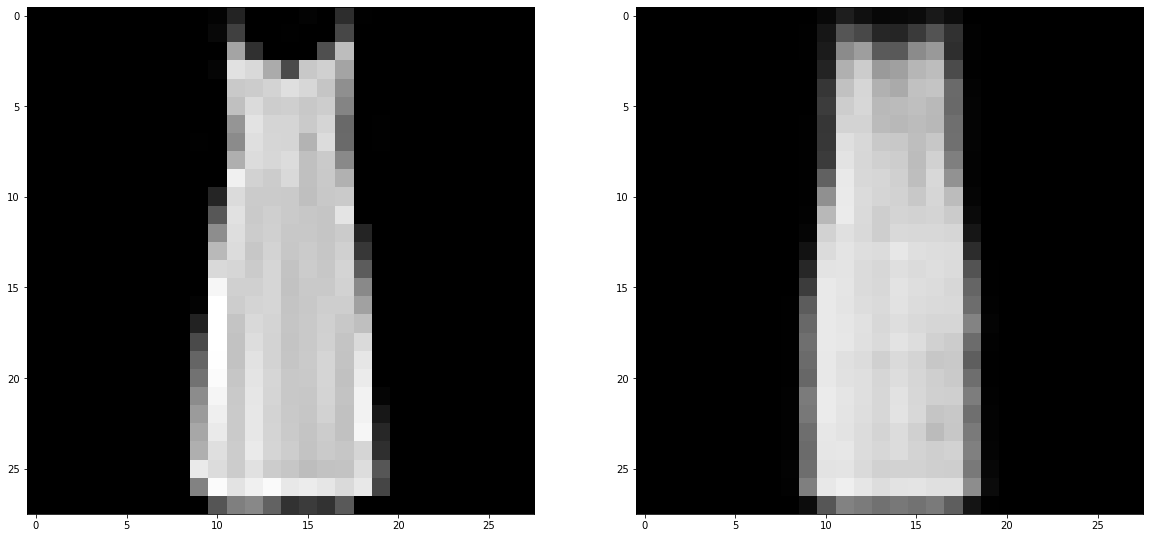

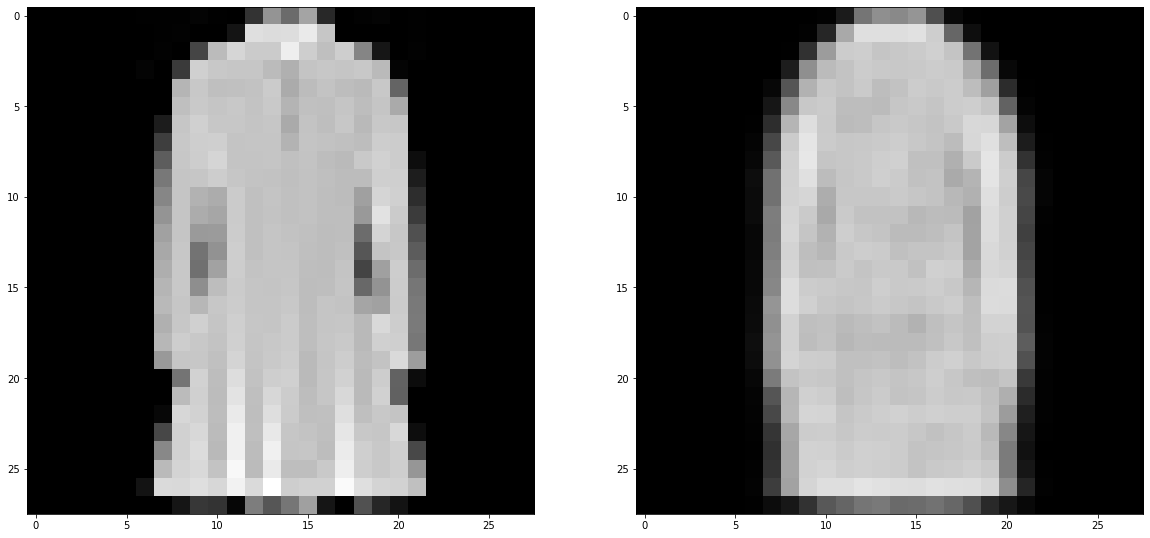

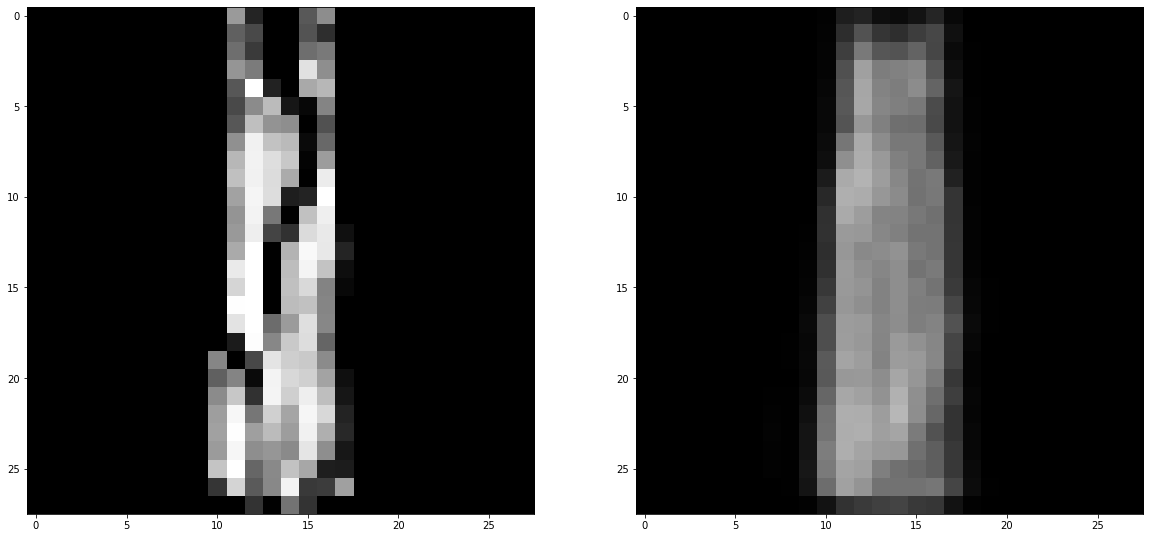

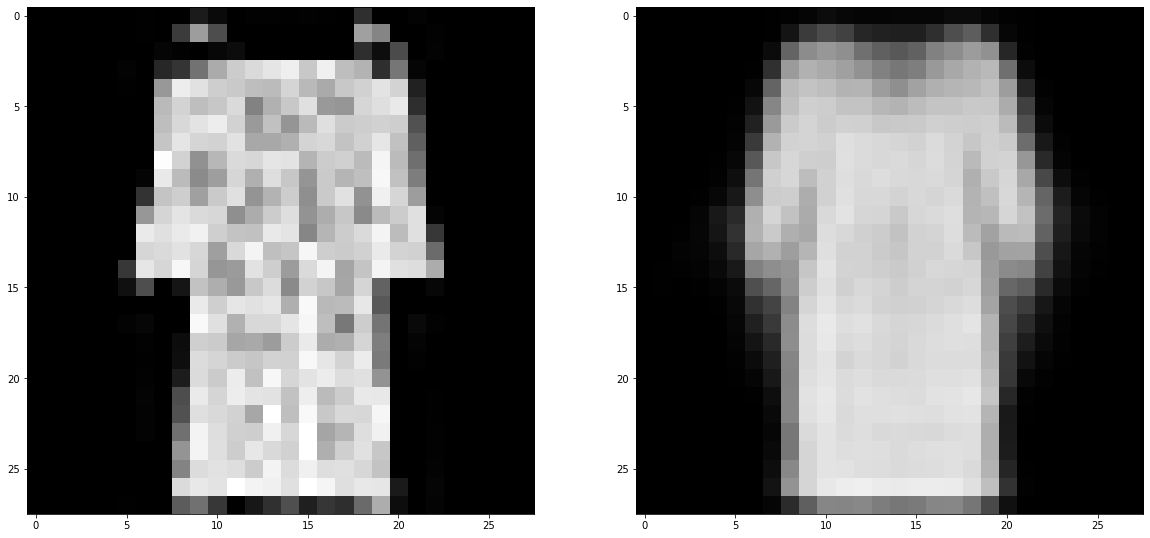

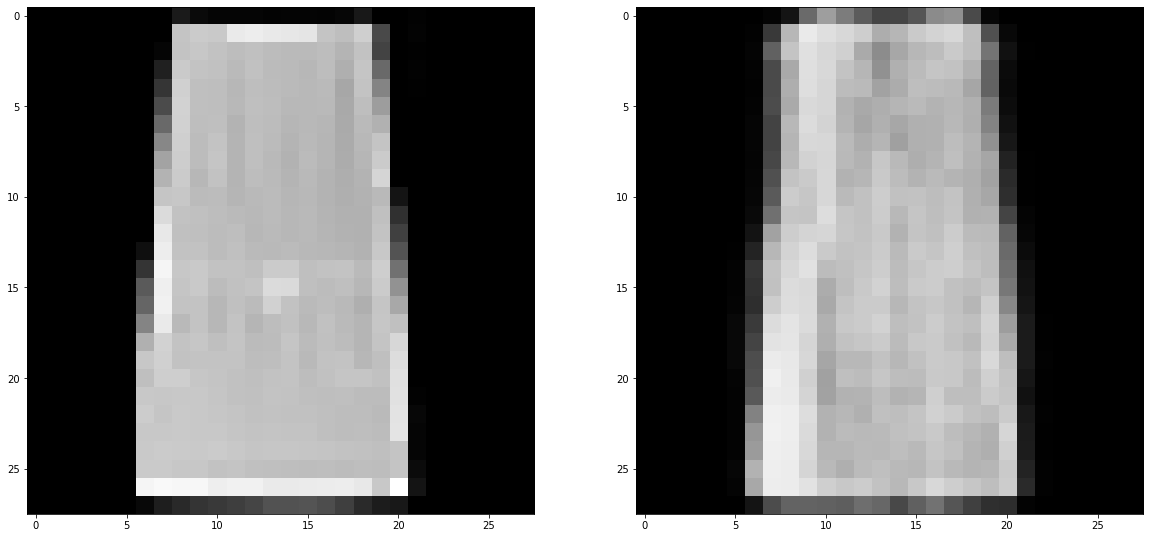

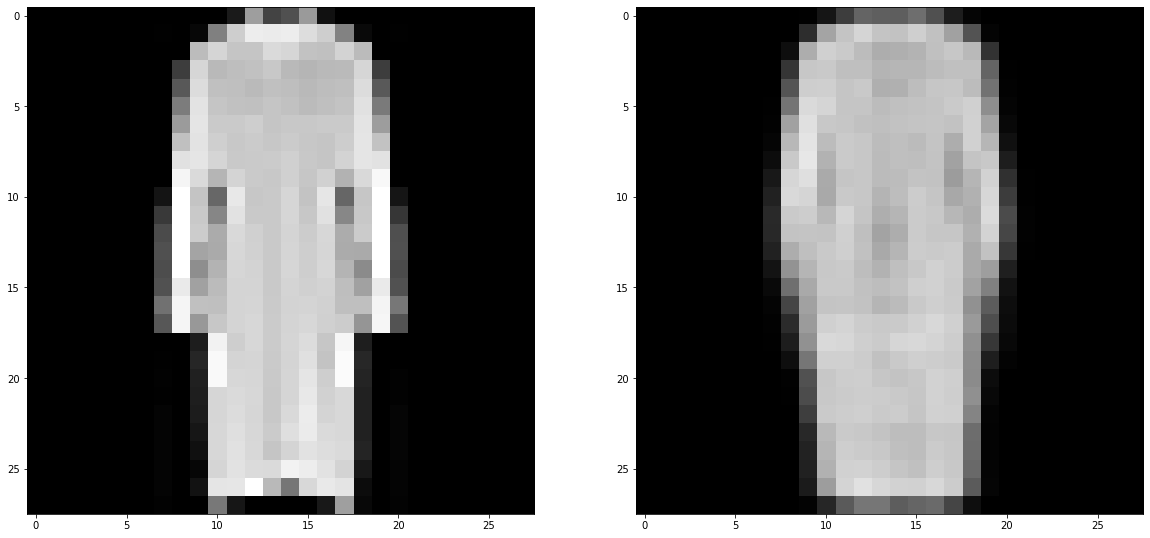

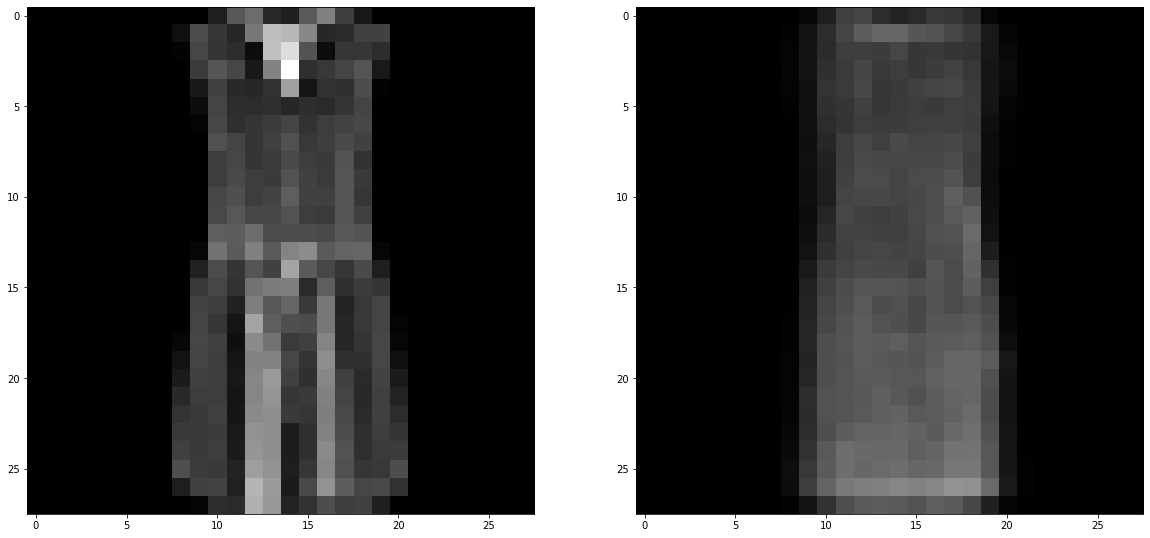

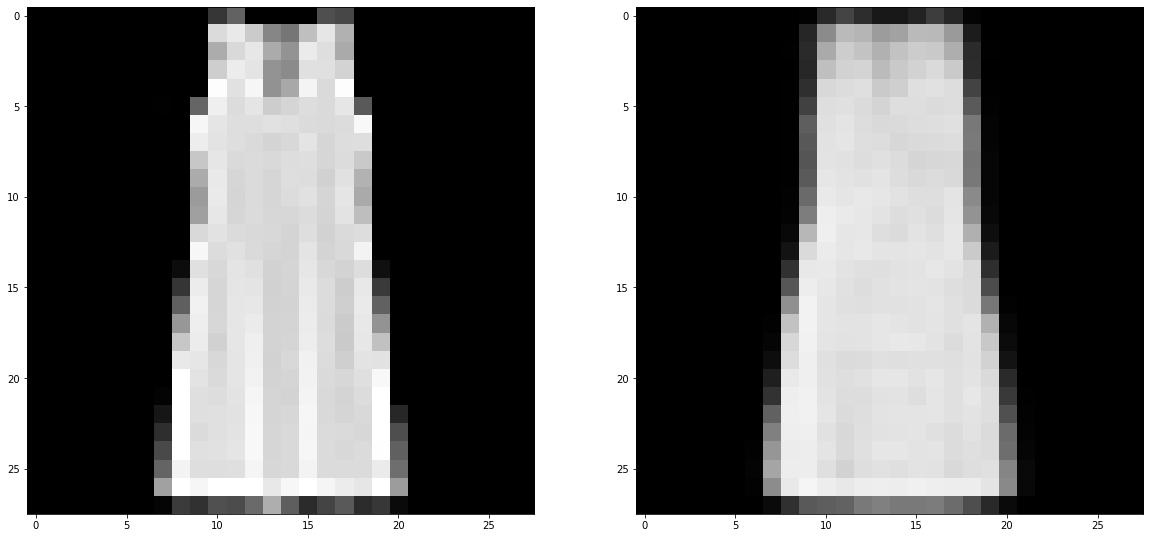

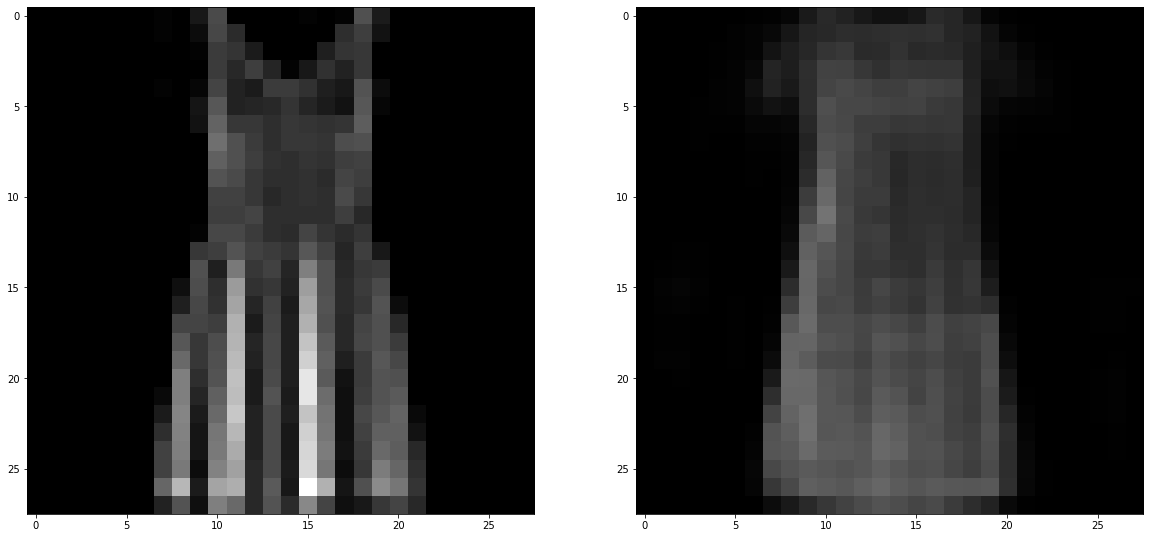

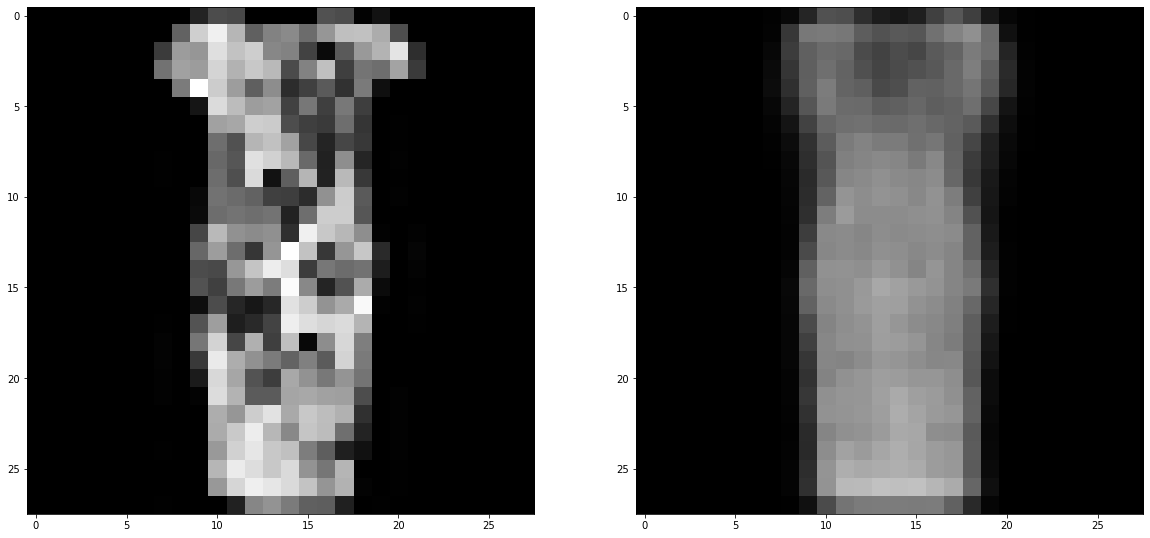

In [13]:
# Dress
class_image_gen(3, vae)

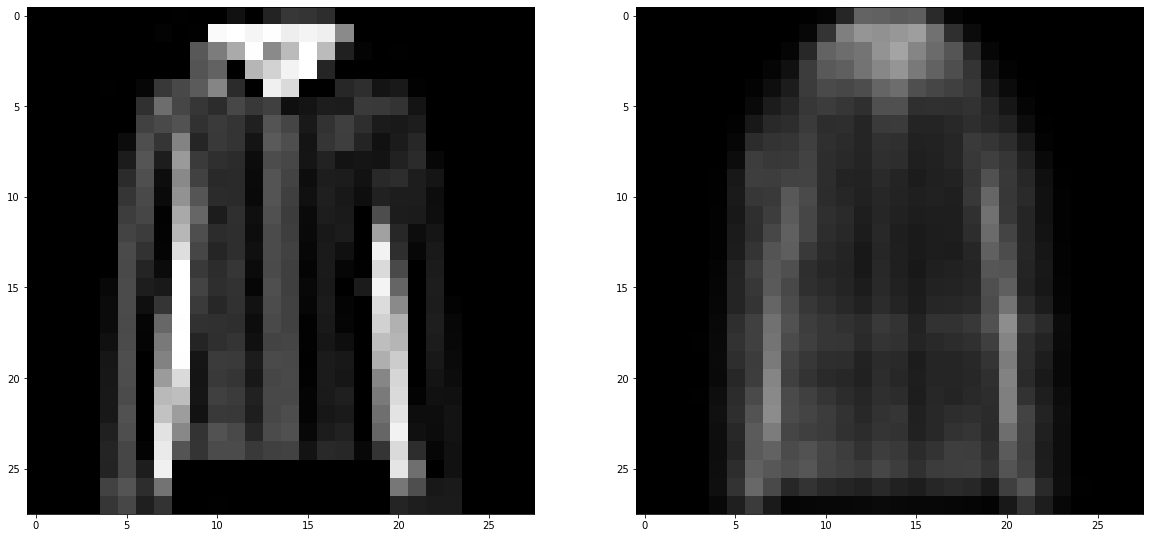

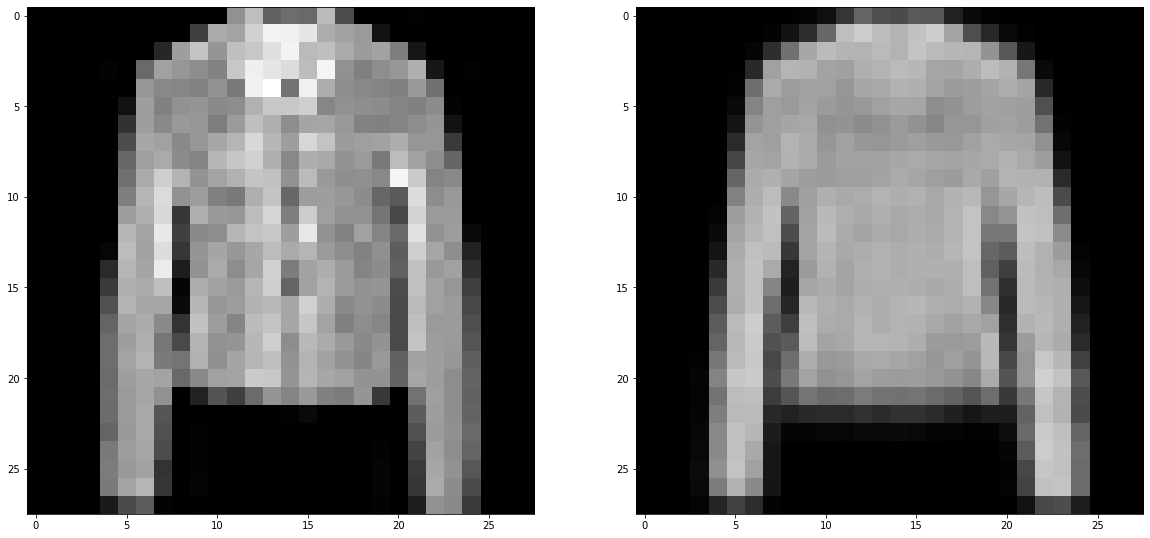

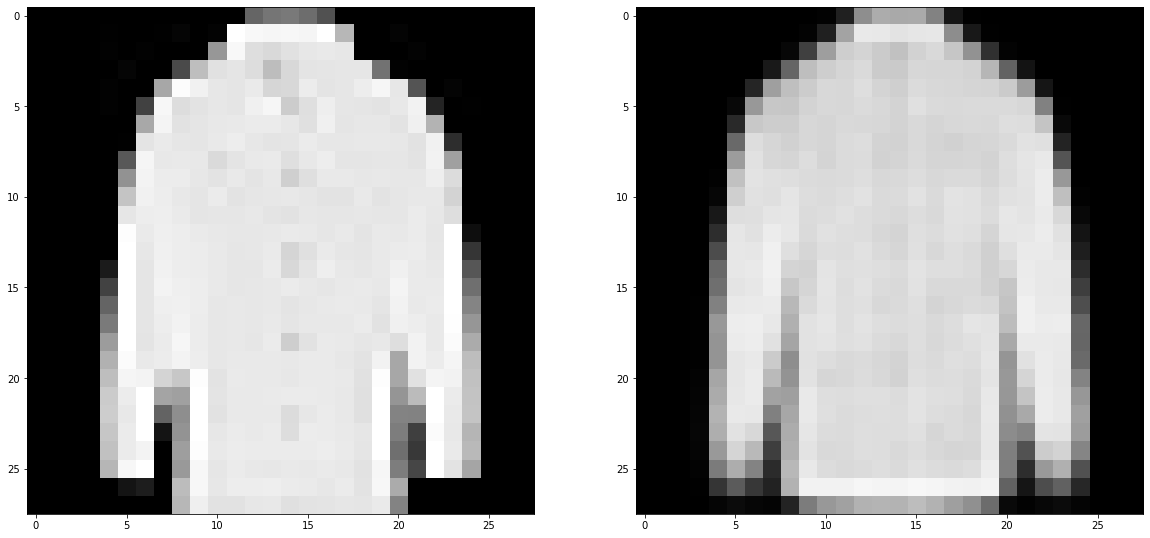

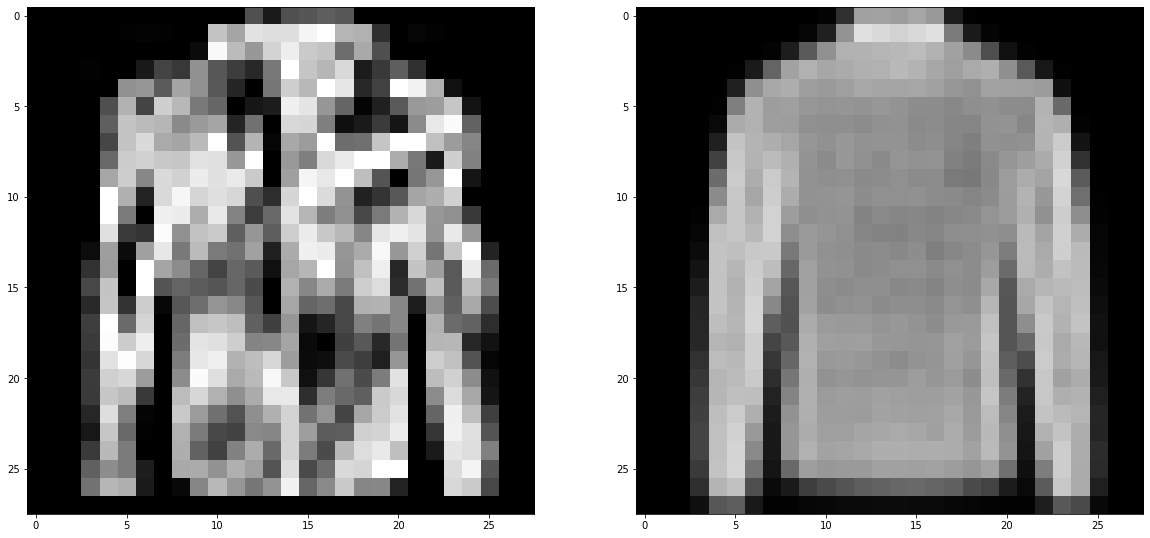

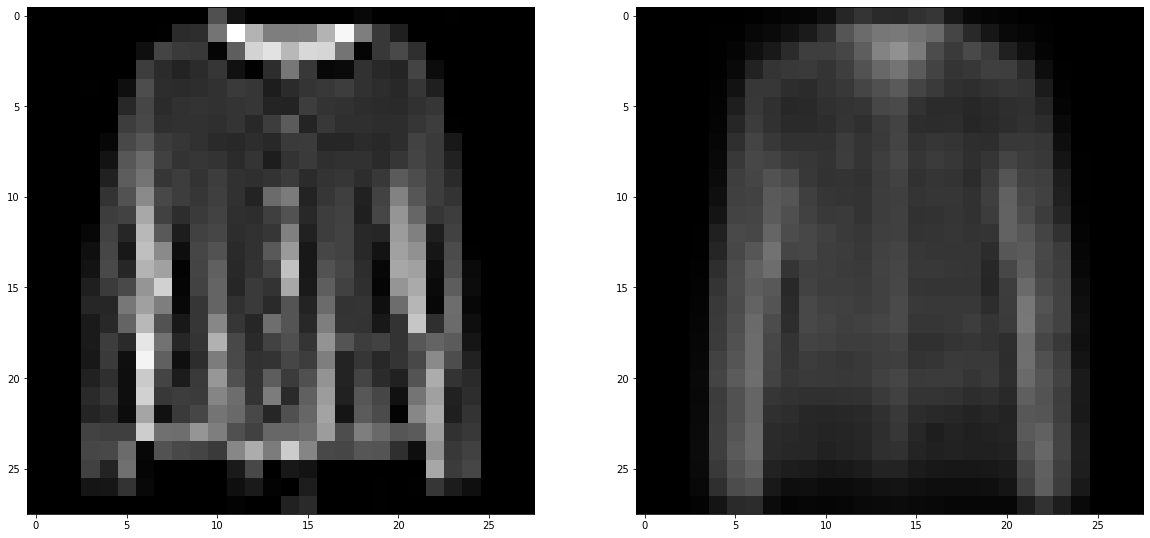

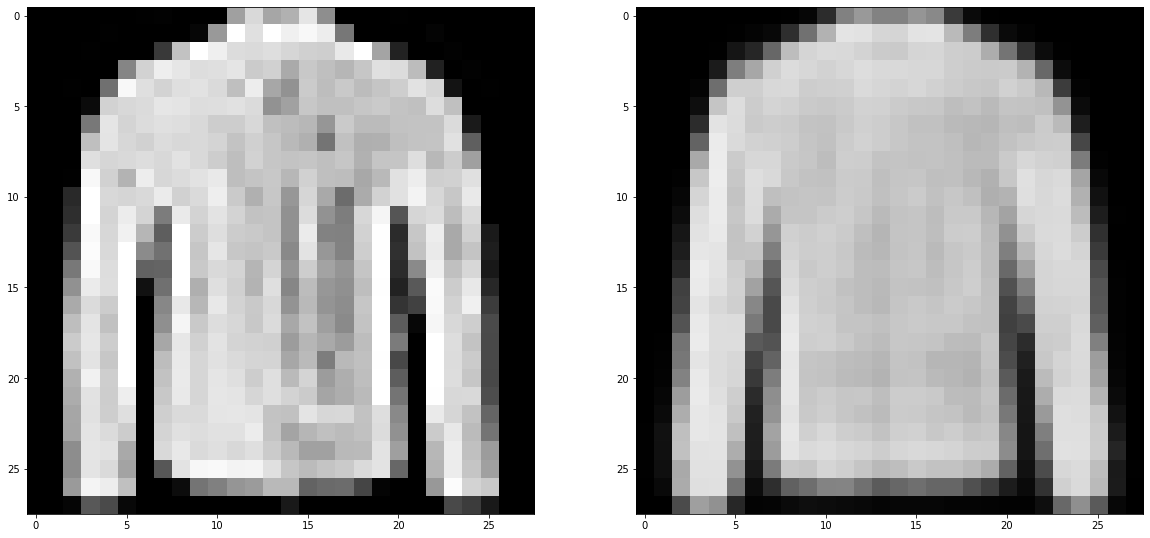

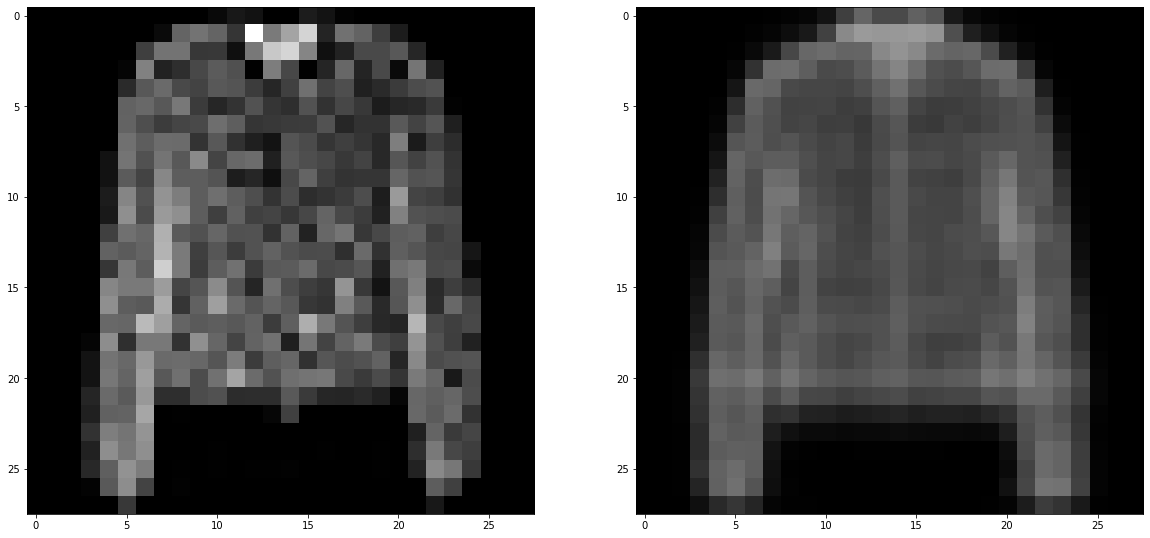

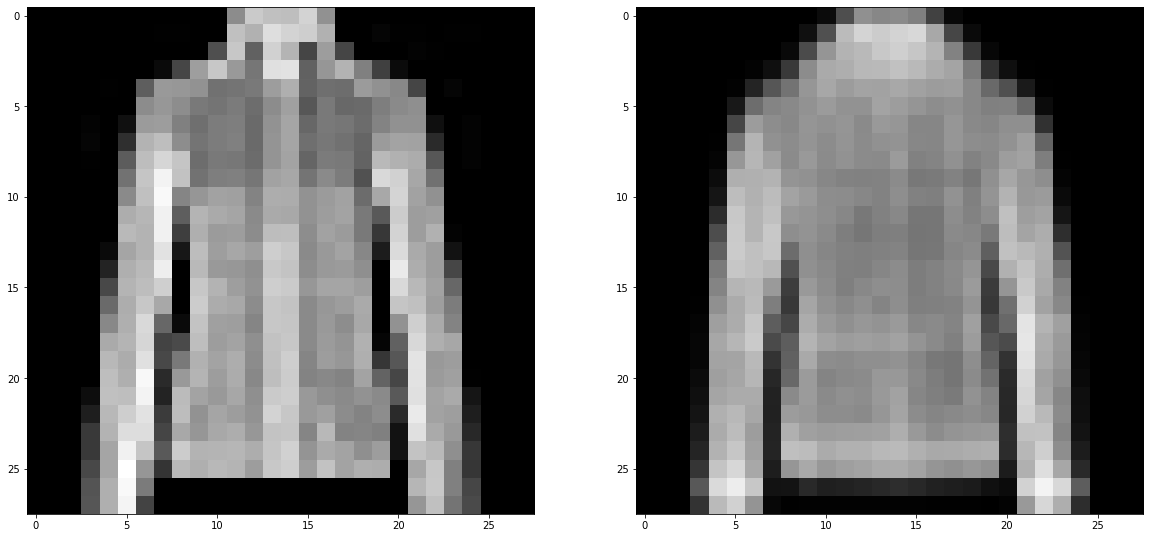

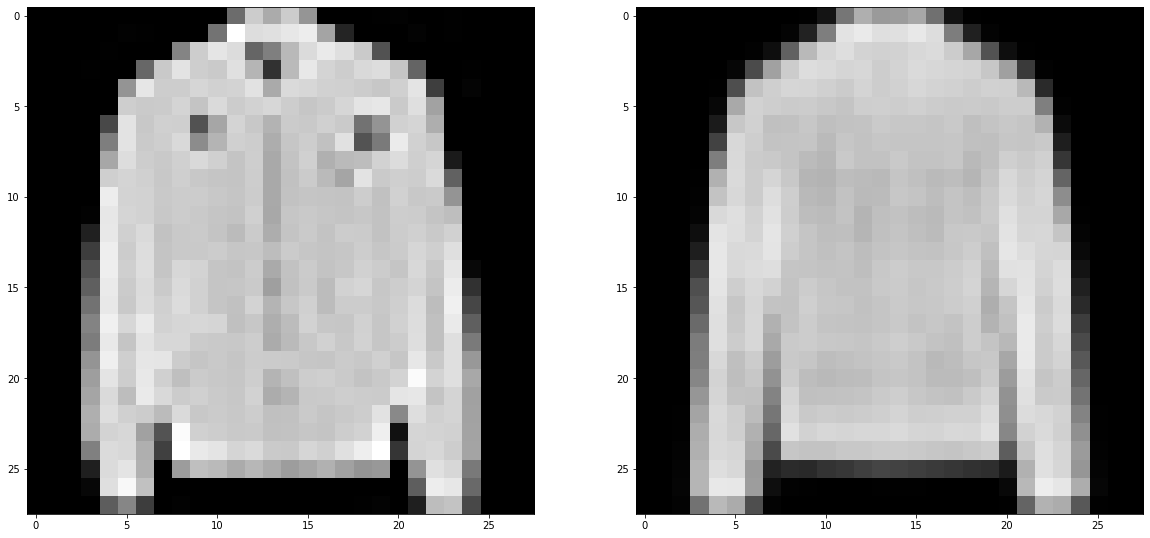

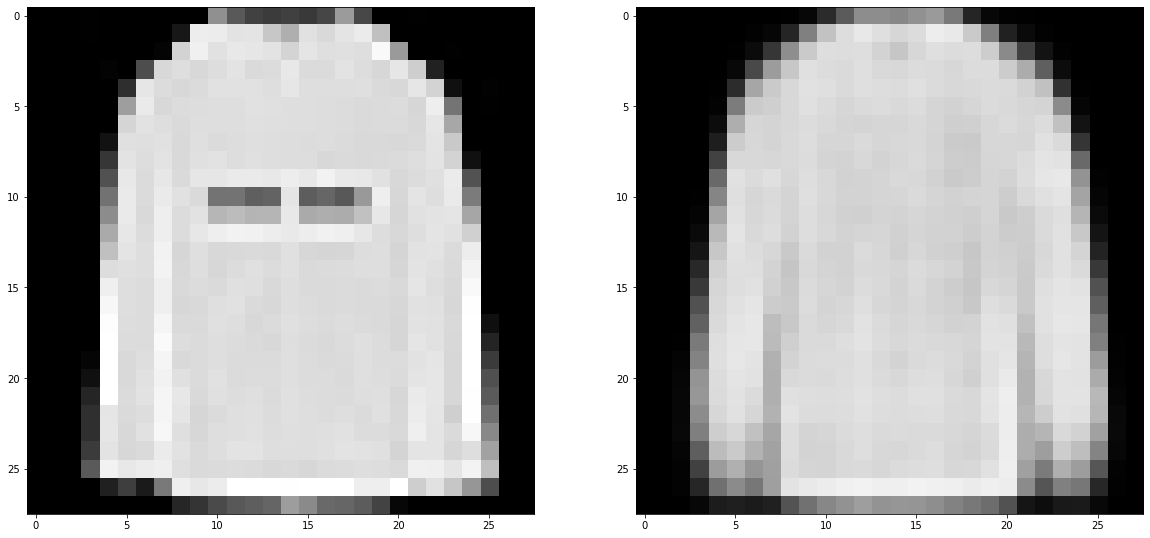

In [14]:
# Coat
class_image_gen(4, vae)

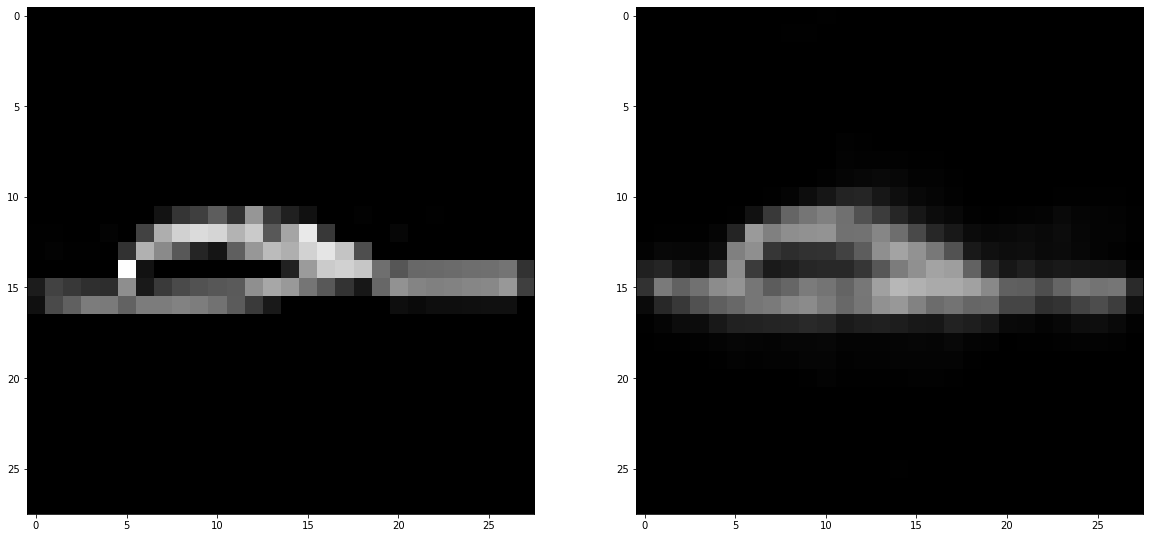

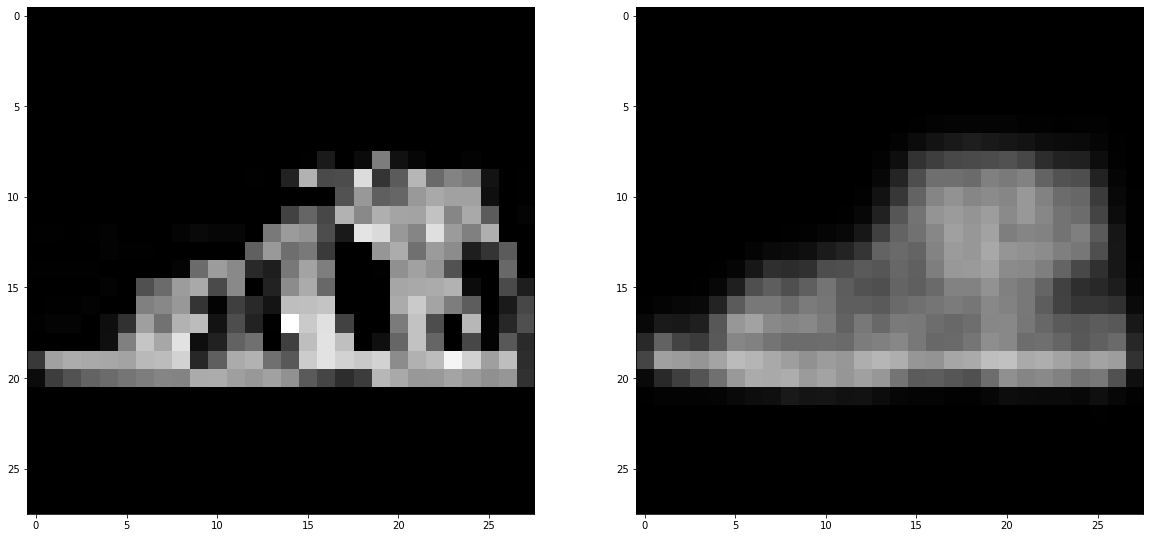

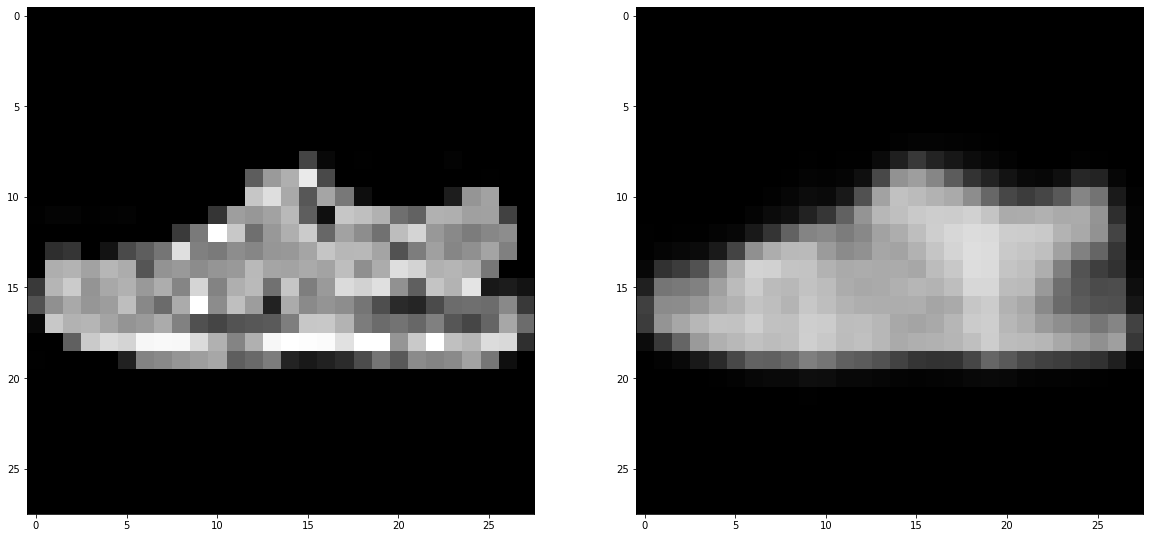

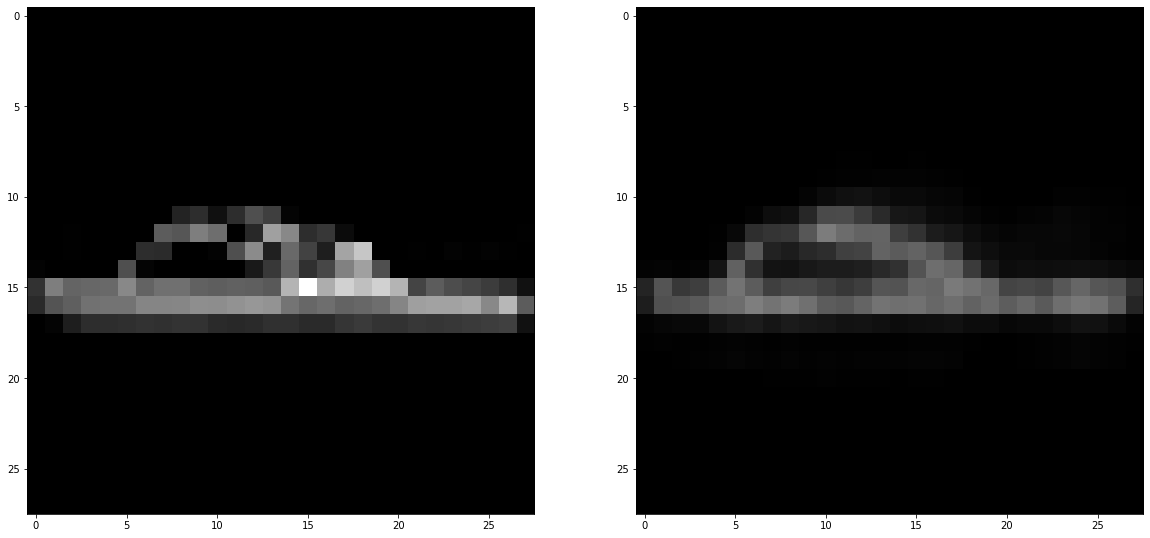

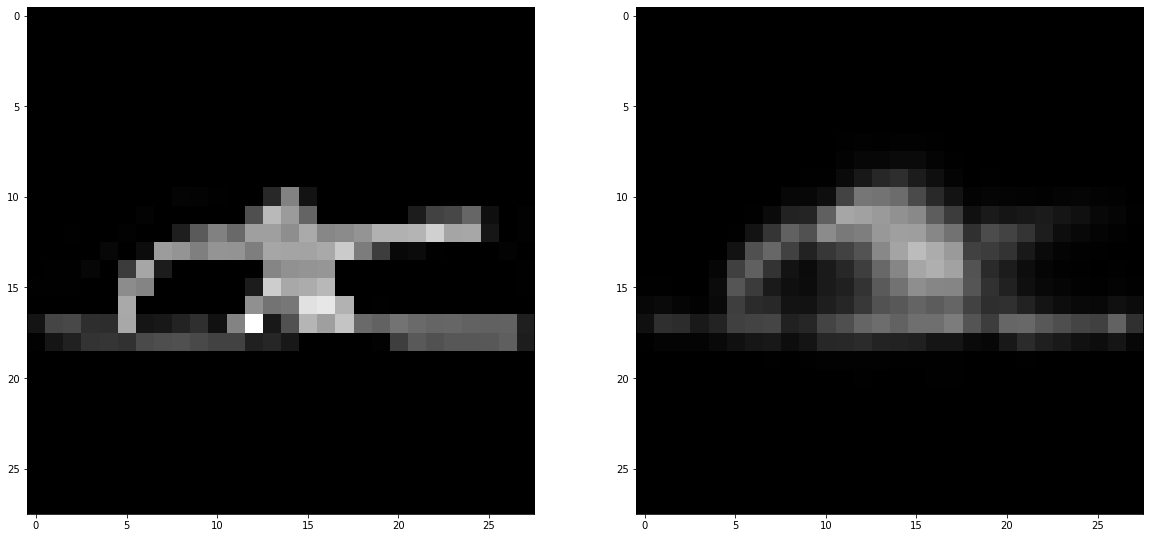

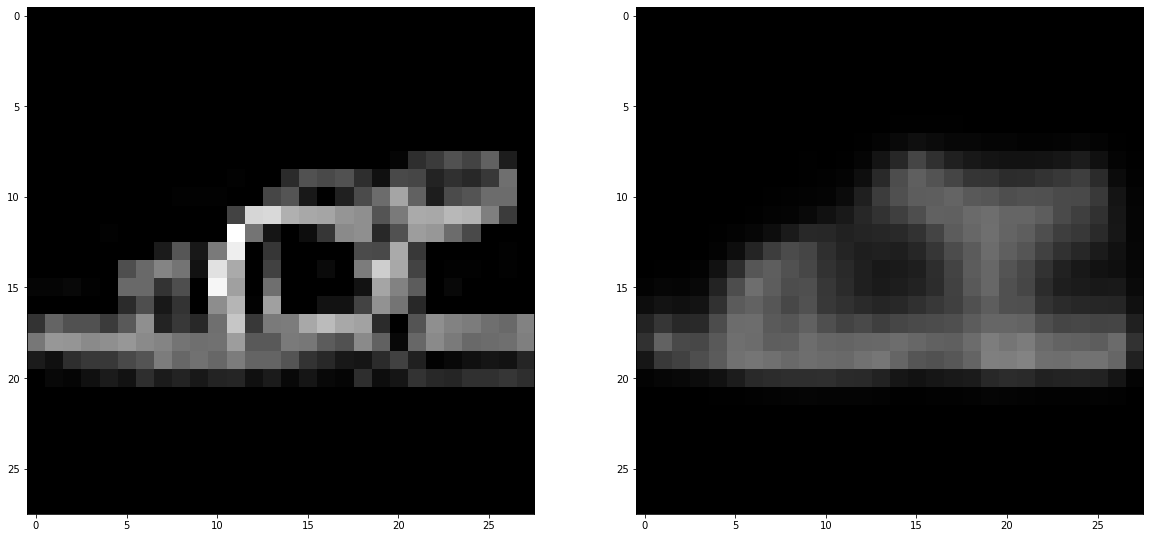

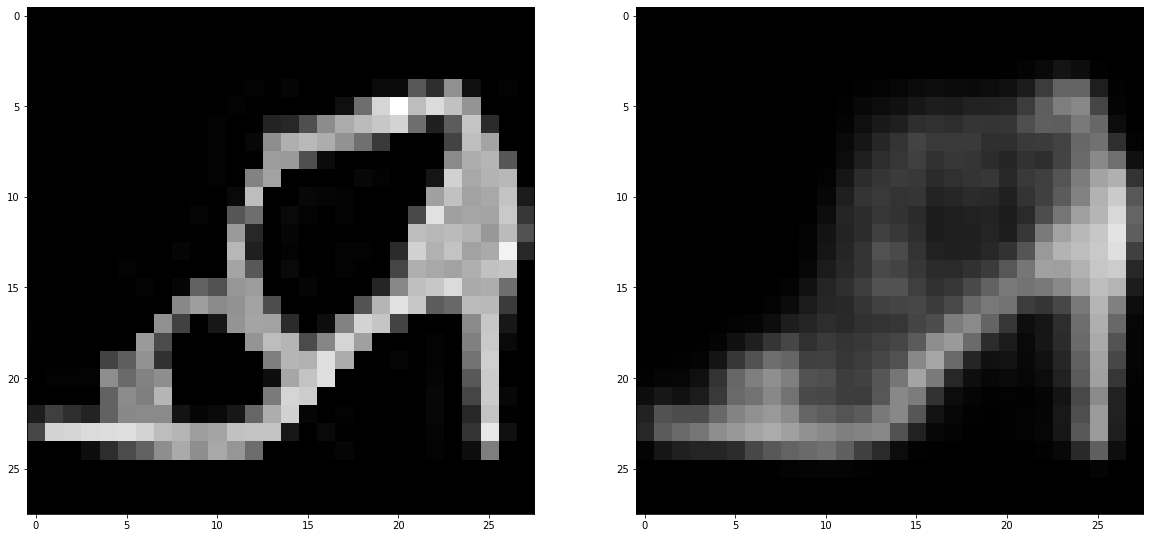

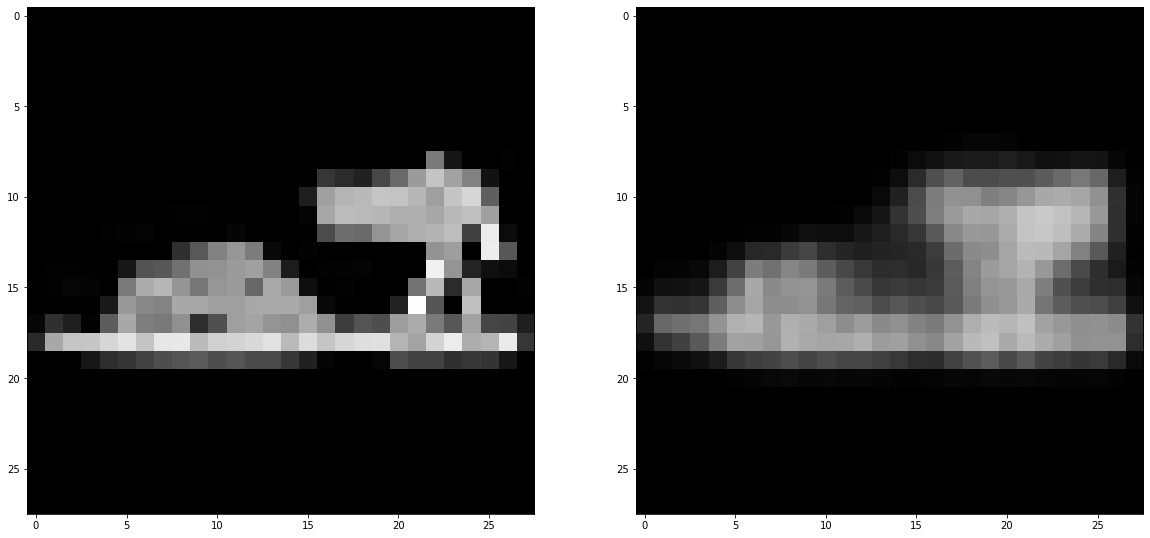

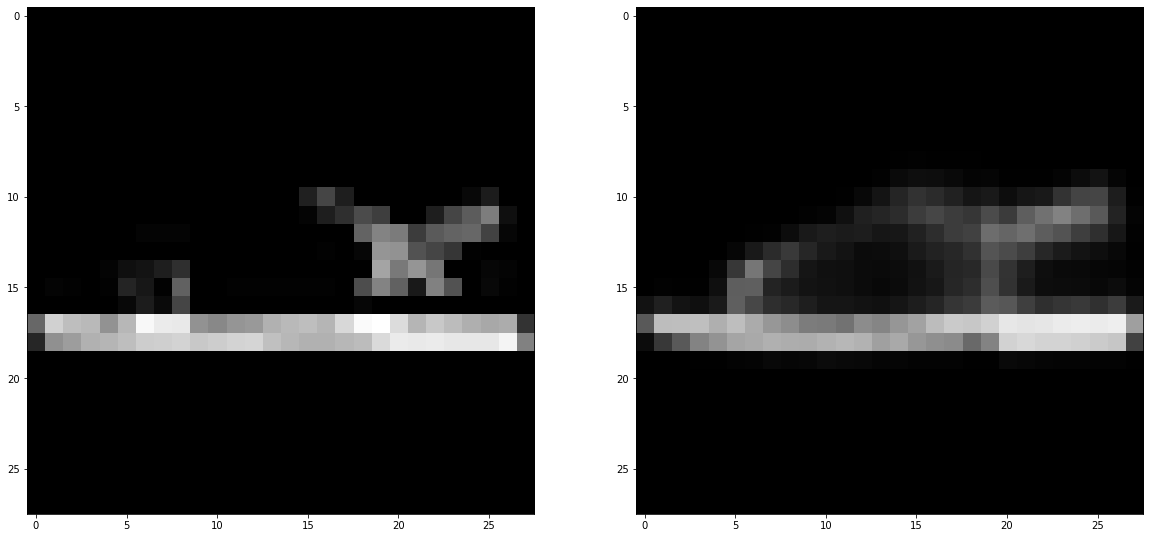

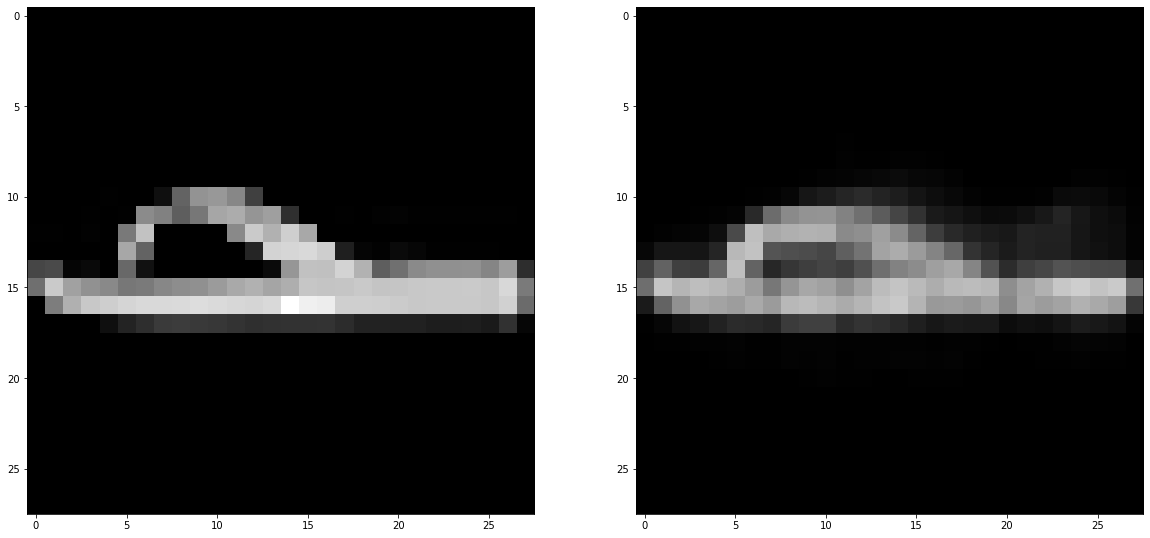

In [15]:
# Sandal
class_image_gen(5, vae)

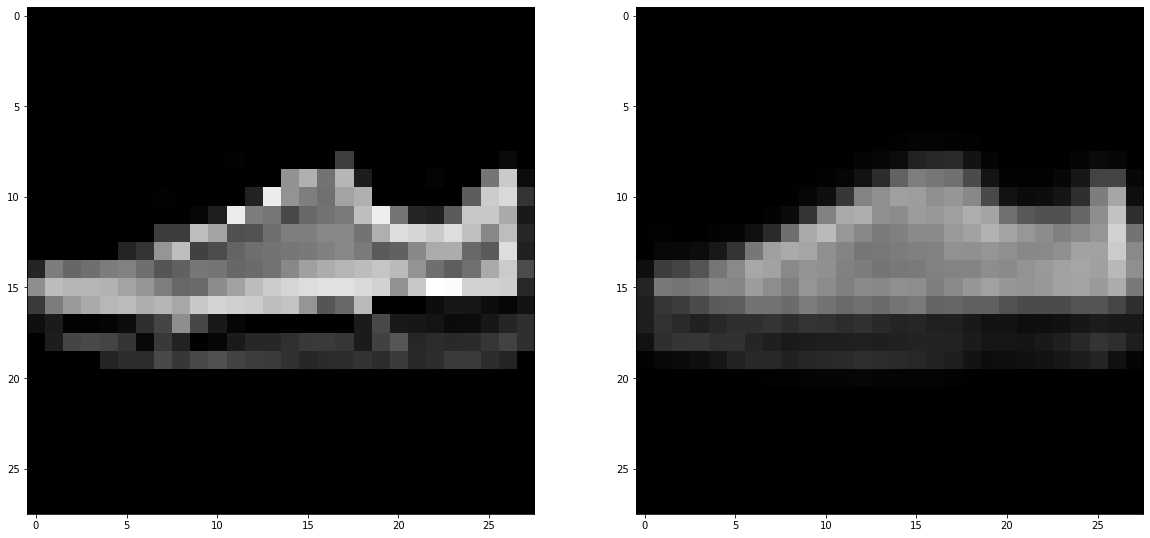

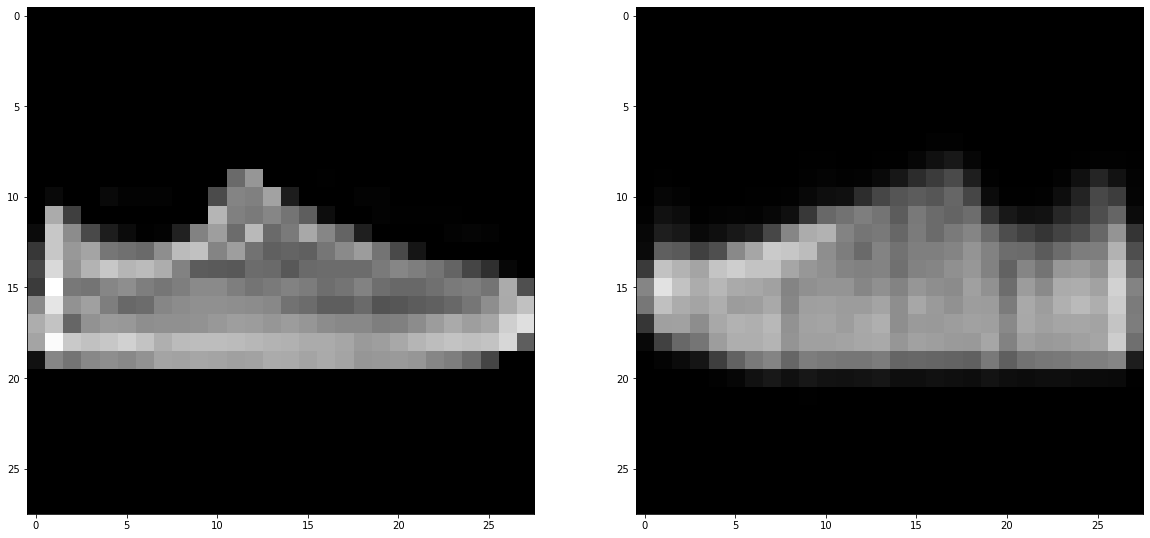

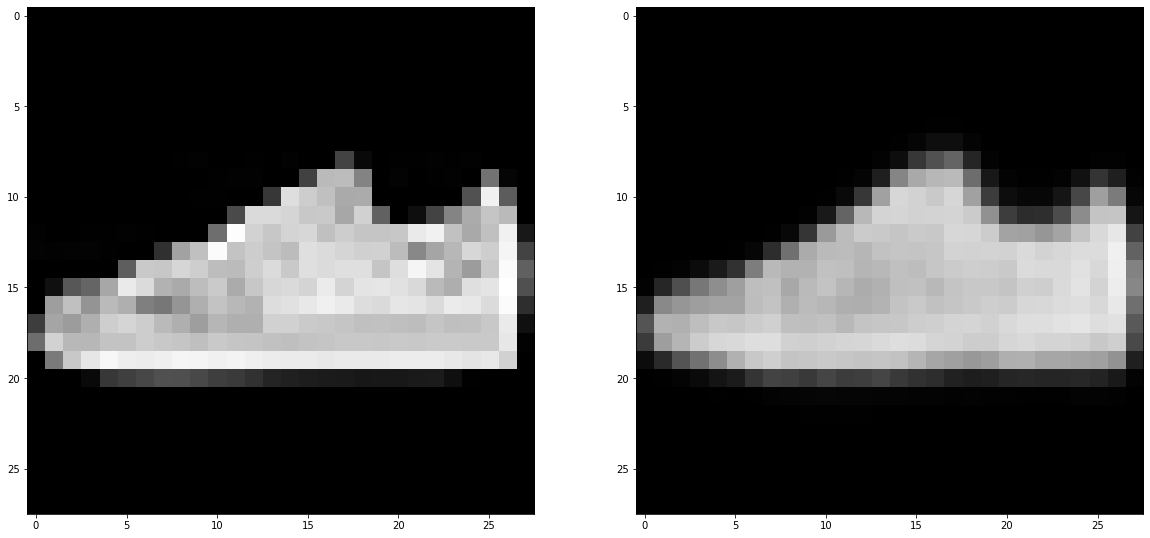

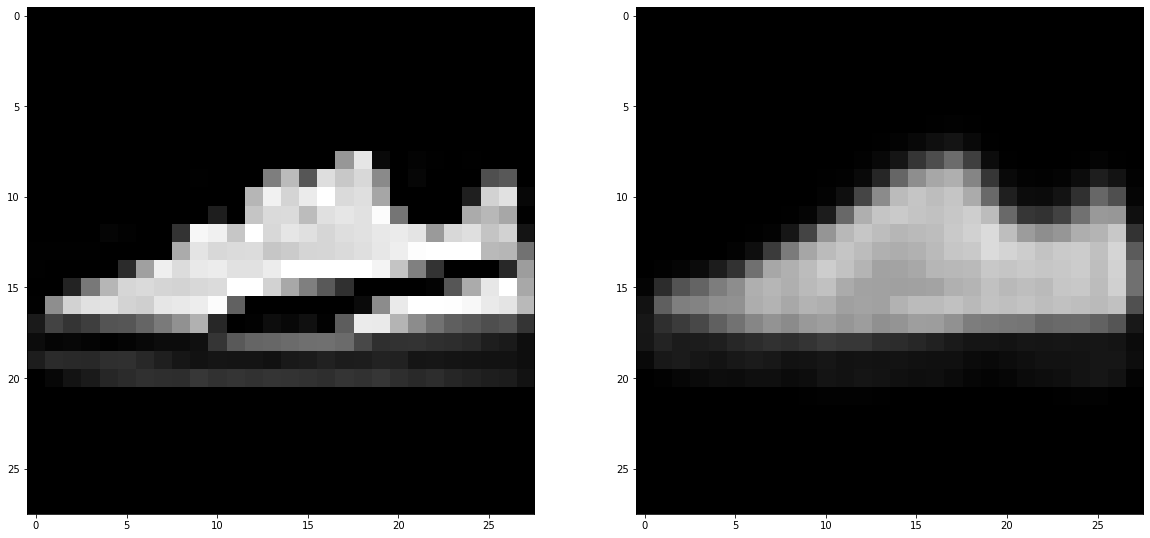

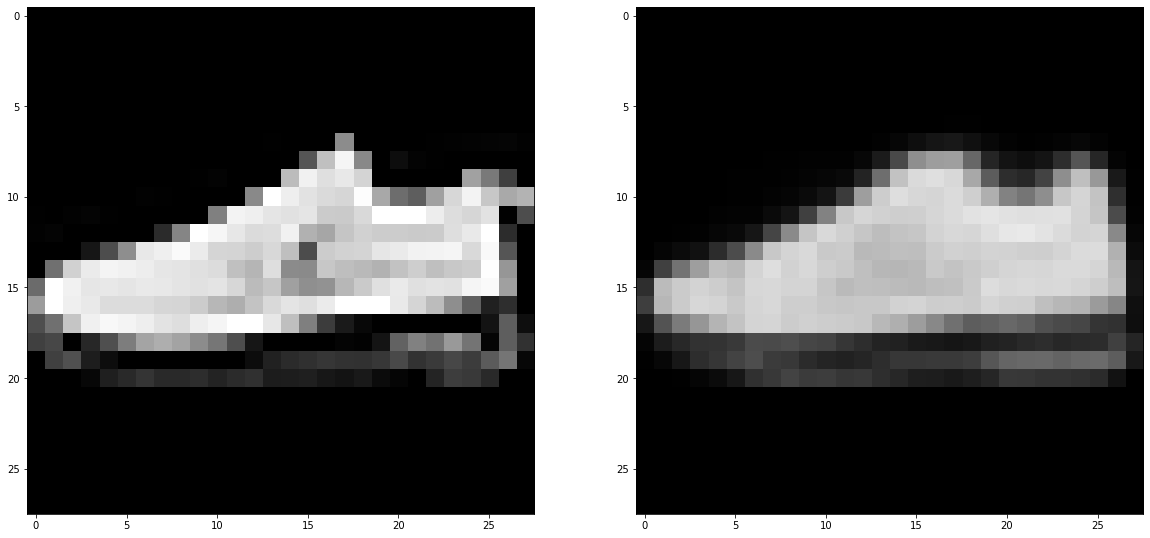

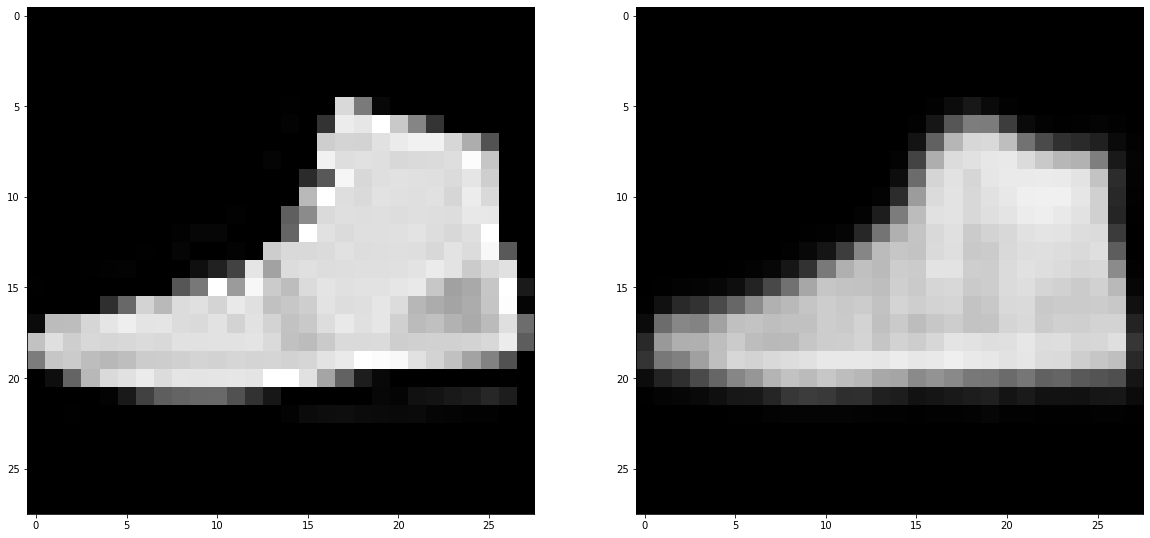

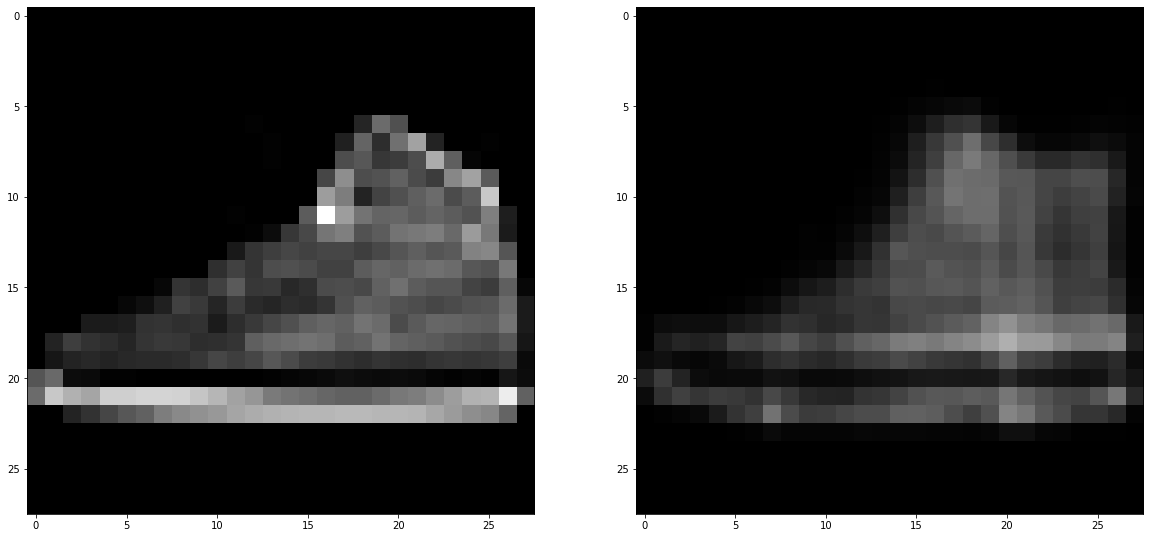

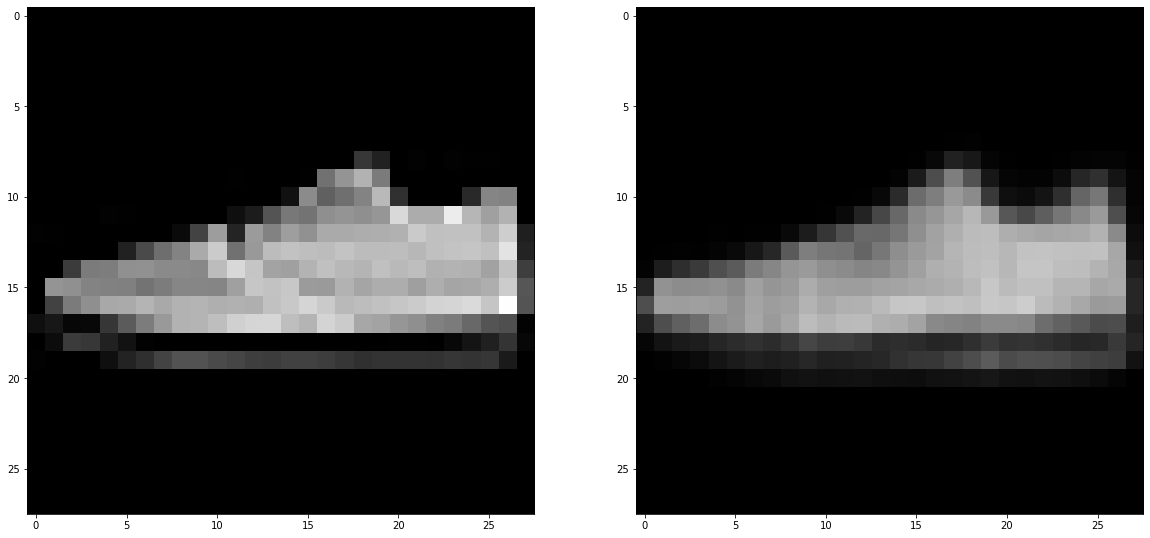

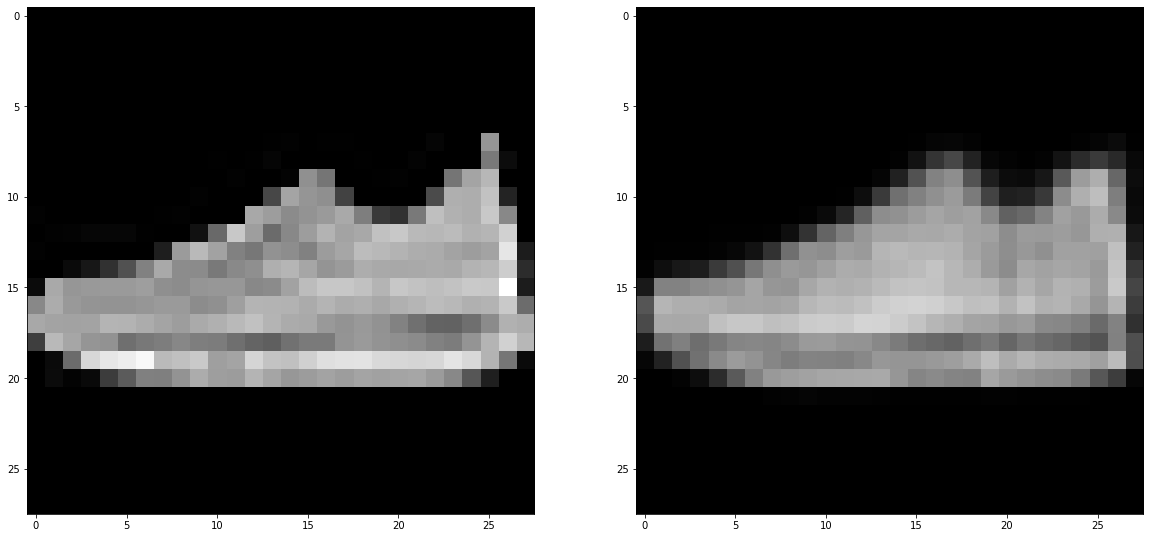

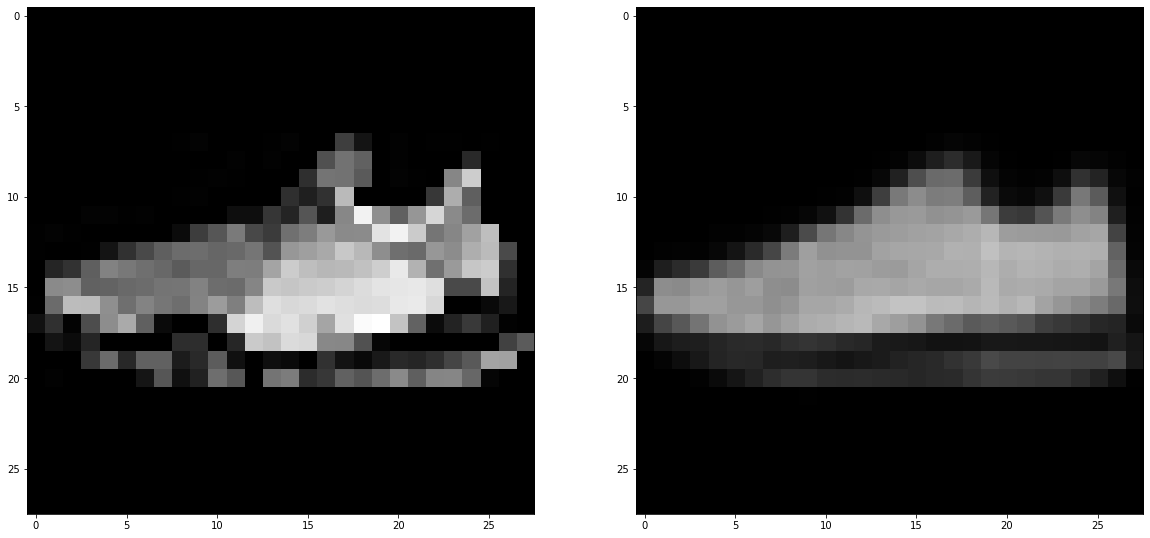

In [16]:
# Sneaker
class_image_gen(7, vae)

Train(1)[0%]: Loss: 70344.3281
Train(1)[50%]: Loss: 39076.2322
Train(1)[100%]: Loss: 36516.3627
Train(2)[0%]: Loss: 33411.4961
Train(2)[50%]: Loss: 33097.0697
Train(2)[100%]: Loss: 32751.3374
Train(3)[0%]: Loss: 32652.5547
Train(3)[50%]: Loss: 32119.1721
Train(3)[100%]: Loss: 32010.7944
Train(4)[0%]: Loss: 31096.3281
Train(4)[50%]: Loss: 31751.1571
Train(4)[100%]: Loss: 31662.5001
Train(5)[0%]: Loss: 32543.8320
Train(5)[50%]: Loss: 31488.3864
Train(5)[100%]: Loss: 31457.1801
Train(6)[0%]: Loss: 30641.6816
Train(6)[50%]: Loss: 31347.6184
Train(6)[100%]: Loss: 31320.7654
Train(7)[0%]: Loss: 30134.9355
Train(7)[50%]: Loss: 31252.6325
Train(7)[100%]: Loss: 31221.5633
Train(8)[0%]: Loss: 32161.8887
Train(8)[50%]: Loss: 31151.4548
Train(8)[100%]: Loss: 31141.3190
Train(9)[0%]: Loss: 30646.2441
Train(9)[50%]: Loss: 31120.4781
Train(9)[100%]: Loss: 31086.1183
Train(10)[0%]: Loss: 30336.4883
Train(10)[50%]: Loss: 31020.0692
Train(10)[100%]: Loss: 31029.0889
Test(10): Loss: 31303.3765


/opt/conda/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/opt/conda/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


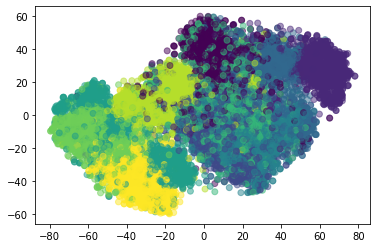

In [1]:
%matplotlib inline

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

import torchvision
import torchvision.transforms as transforms
from torchvision.utils import make_grid

import matplotlib.pyplot as plt
import numpy as np

import sklearn
from sklearn.manifold import TSNE

batch_size = 128
train_set, test_set, train_loader, test_loader = {},{},{},{}
transform = transforms.Compose(
    [transforms.ToTensor()])

train_set['fashionmnist'] = torchvision.datasets.FashionMNIST(root='./data', train=True, download=True, transform=transform)
test_set['fashionmnist'] = torchvision.datasets.FashionMNIST(root='./data', train=False, download=True, transform=transform)

train_loader['fashionmnist'] = torch.utils.data.DataLoader(train_set['fashionmnist'], batch_size=batch_size, shuffle=True, num_workers=0)
test_loader['fashionmnist'] = torch.utils.data.DataLoader(test_set['fashionmnist'], batch_size=batch_size, shuffle=False, num_workers=0)

device = 'cuda'

class VAE(nn.Module):
    def __init__(self, n_in, n_hid, z_dim):
        super(VAE, self).__init__()

        self.fc1 = nn.Linear(n_in, n_hid)
        self.fc21 = nn.Linear(n_hid, z_dim)
        self.fc22 = nn.Linear(n_hid, z_dim)
        self.fc3 = nn.Linear(z_dim, n_hid)
        self.fc4 = nn.Linear(n_hid, n_in)

    def encode(self, x):
        h1 = F.relu(self.fc1(x))
        return self.fc21(h1), self.fc22(h1)

    def reparameterize(self, mu, logvar):
        stdev = torch.exp(0.5*logvar)
        eps = torch.randn_like(stdev)
        return mu + eps*stdev

    def decode(self, z):
        h3 = F.relu(self.fc3(z))
        return torch.sigmoid(self.fc4(h3))

    def forward(self, x):
        mu, logvar = self.encode(x)
        z = self.reparameterize(mu, logvar)
        return self.decode(z), mu, logvar

def loss_function(recon_x, x, mu, logvar):
    BCE = F.binary_cross_entropy(recon_x, x, reduction='sum') # BCE = -Negative Log-likelihood
    KLD = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp()) # KL Divergence b/w q_\phi(z|x) || p(z)
    return BCE + KLD

def train(model, device, train_loader, optimizer, epoch):
    train_loss = 0
    model.train()
    for batch_idx, (data, target) in enumerate(train_loader):
        data = data.view(data.size(0),-1)
        data = data.to(device)
        
        optimizer.zero_grad()
        output, mu, logvar = model(data)
        loss = loss_function(output, data, mu, logvar)
        loss.backward()
        optimizer.step()
        train_loss += loss.item()
        if batch_idx % (len(train_loader)//2) == 0:
            print('Train({})[{:.0f}%]: Loss: {:.4f}'.format(
                epoch, 100. * batch_idx / len(train_loader), train_loss/(batch_idx+1)))
    return train_loss

def test(model, device, test_loader, epoch):
    model.eval()
    test_loss = 0
    with torch.no_grad():
        for data, target in test_loader:
            data = data.view(data.size(0),-1)
            data = data.to(device)
            output, mu, logvar = model(data)
            loss = loss_function(output, data, mu, logvar)
            test_loss += loss.item() # sum up batch loss
    test_loss = (test_loss*batch_size)/len(test_loader.dataset)
    print('Test({}): Loss: {:.4f}'.format(
        epoch, test_loss))
    return test_loss

def make_optimizer(optimizer_name, model, **kwargs):
    if optimizer_name=='Adam':
        optimizer = optim.Adam(model.parameters(),lr=kwargs['lr'])
    elif optimizer_name=='SGD':
        optimizer = optim.SGD(model.parameters(),lr=kwargs['lr'],momentum=kwargs['momentum'], weight_decay=kwargs['weight_decay'])
    else:
        raise ValueError('Not valid optimizer name')
    return optimizer

seed = 1
data_name = 'fashionmnist'
optimizer_name = 'Adam'

num_epochs = 10
lr = 0.001
n_in = 28*28
n_hid = 400
z_dim = 20

device = torch.device(device)
torch.manual_seed(seed)
torch.cuda.manual_seed(seed)

vae = VAE(n_in, n_hid, z_dim).to(device)

optimizer = make_optimizer(optimizer_name, vae, lr=lr)

for epoch in range(1, num_epochs + 1):
    train(vae, device, train_loader[data_name], optimizer, epoch)

test(vae, device, test_loader[data_name], epoch)

def plot_manifold(input_model):
    latent_vectors = []
    latent_targets = []
    i = 0 
    with torch.no_grad():
        for data, target in test_loader['fashionmnist']:
            data = data.view(data.size(0),-1)
            data = data.to(device)
            mu, logvar = input_model.encode(data)
            out_vector = input_model.reparameterize(mu, logvar) 
            if i == 0:
                latent_vectors = out_vector
                latent_targets = target
                i += 1
            else:
                latent_vectors = torch.cat((latent_vectors,out_vector),0)
                latent_targets = torch.cat((latent_targets,target),0)
        
    manifold_data = TSNE(n_components=2).fit_transform(latent_vectors.cpu())
        
    fig = plt.figure()
    plt.scatter(manifold_data[:, 0], manifold_data[:, 1], c=latent_targets, alpha=0.5)
    plt.show()
        
plot_manifold(vae)

When comparing the 2D latent space feature representations produced utilizing the T-SNE dimensionality reduction technique, it can be observed that in the representation yielded by the standard VAE, encodings (vectors) of different classes are less contiguous - latent vectors of different classes are further apart. For example, the class vectors denoted using yellow is concentrated within a specific region of the representation essentially isolated from vectors of different classes. In the representation yielded by the c-VAE where vectors of different classes are closer together (more contiguous). Therefore, it can be concluded that the encoding yielded by the c-VAE enables easier interpolation and sampling and its more desirable in comparison to the standard VAE. 